### Data Dictionary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score

### Understanding the structure of the data

In [2]:
# run the following lines for Google Colab
from google.colab import drive
drive.mount('/content/drive')
file_path_stock_data = '/content/drive/MyDrive/stock_data.csv'

Mounted at /content/drive


In [3]:
# Write your code here to read the data
stock_data_df = pd.read_csv(file_path_stock_data, encoding='latin1')

### Initial Data Inspection

In [4]:
## Initial Data Inspection
print("Dataset Shape:", stock_data_df.shape)
print("\nDataset Info:")
stock_data_df.info()

print("\nDataset Description:")
print(stock_data_df.describe())

# Checking for Missing Values
print("\nMissing Values:")
print(stock_data_df.isnull().sum())

Dataset Shape: (340, 15)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticker Symbol                 340 non-null    object 
 1   Security                      340 non-null    object 
 2   GICS Sector                   340 non-null    object 
 3   GICS Sub Industry             340 non-null    object 
 4   Current Price                 340 non-null    float64
 5   Price Change                  340 non-null    float64
 6   Volatility                    340 non-null    float64
 7   ROE                           340 non-null    int64  
 8   Cash Ratio                    340 non-null    int64  
 9   Net Cash Flow                 340 non-null    int64  
 10  Net Income                    340 non-null    int64  
 11  Earnings Per Share            340 non-null    float64
 12  Estimated Shares Outstan

### Exploratory Data Analysis

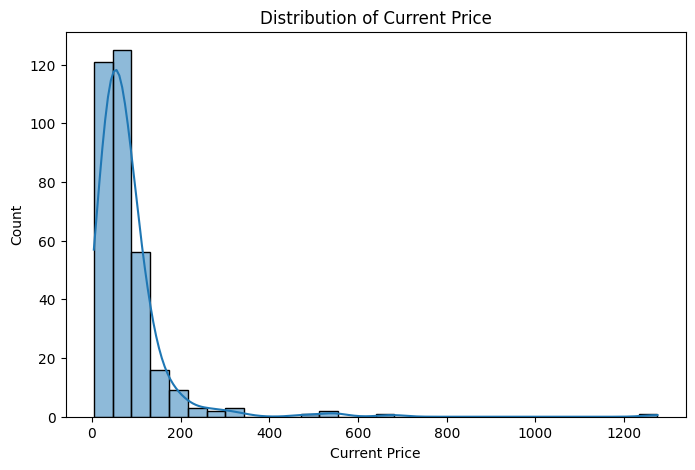

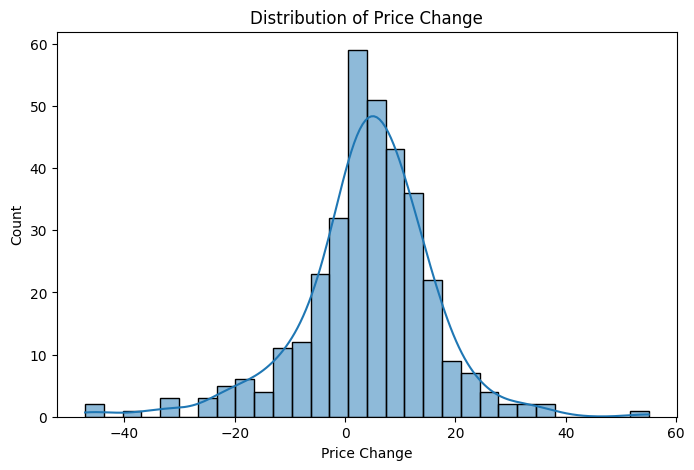

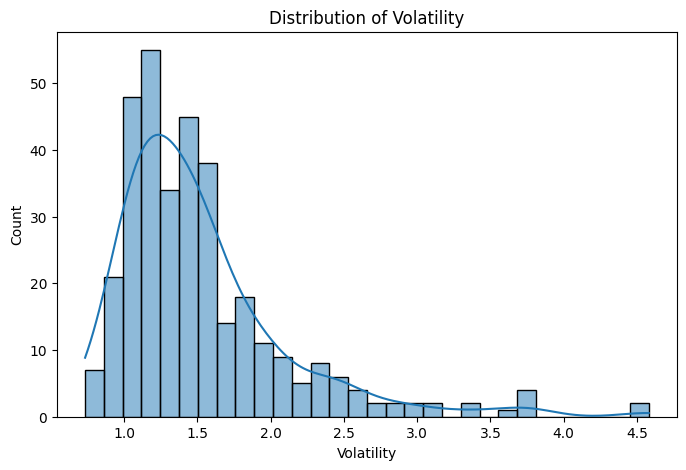

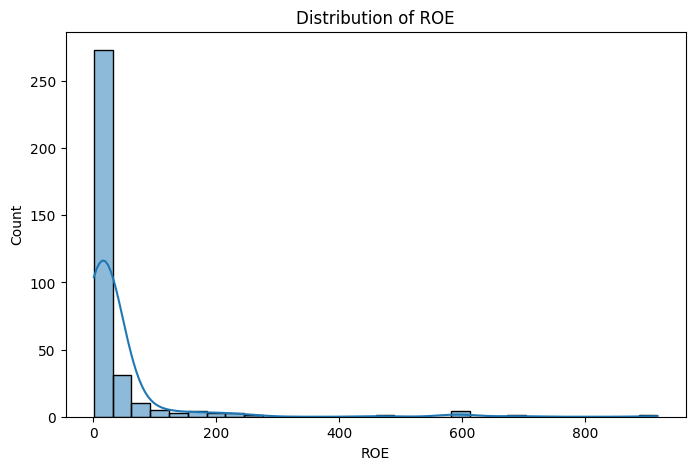

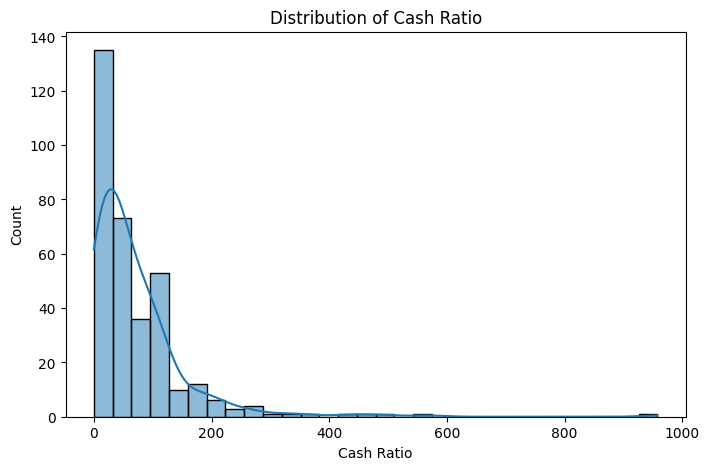

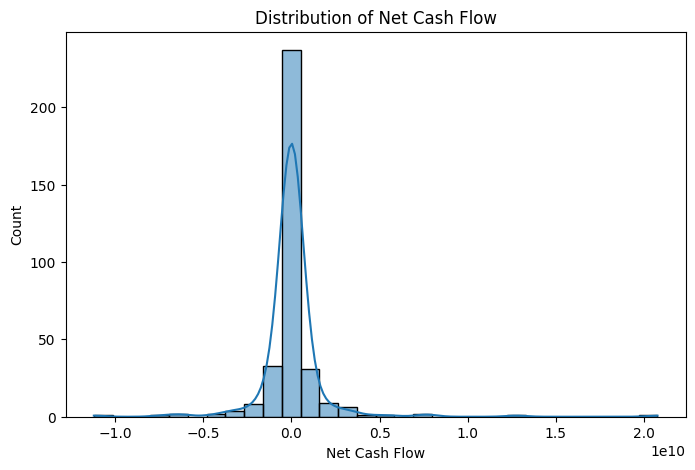

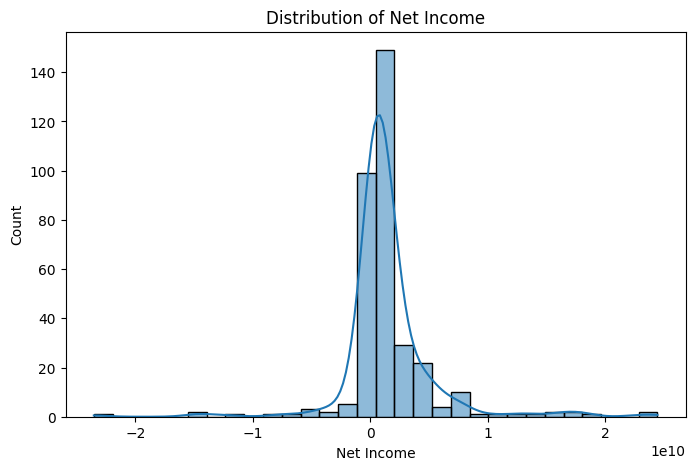

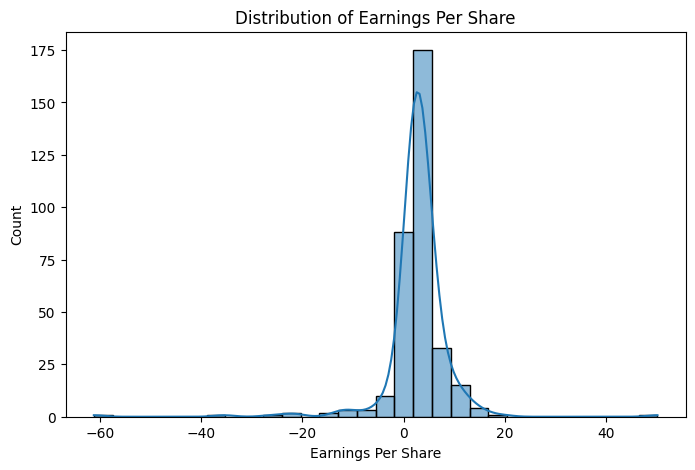

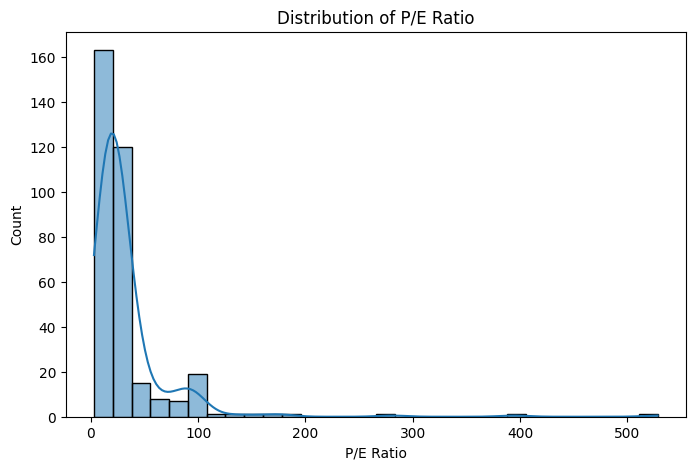

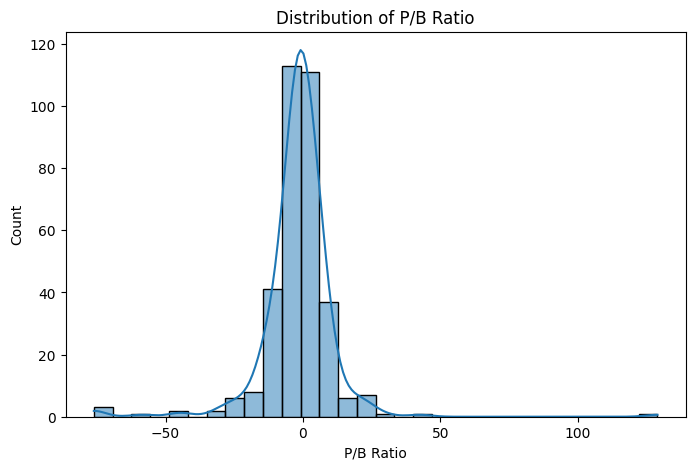

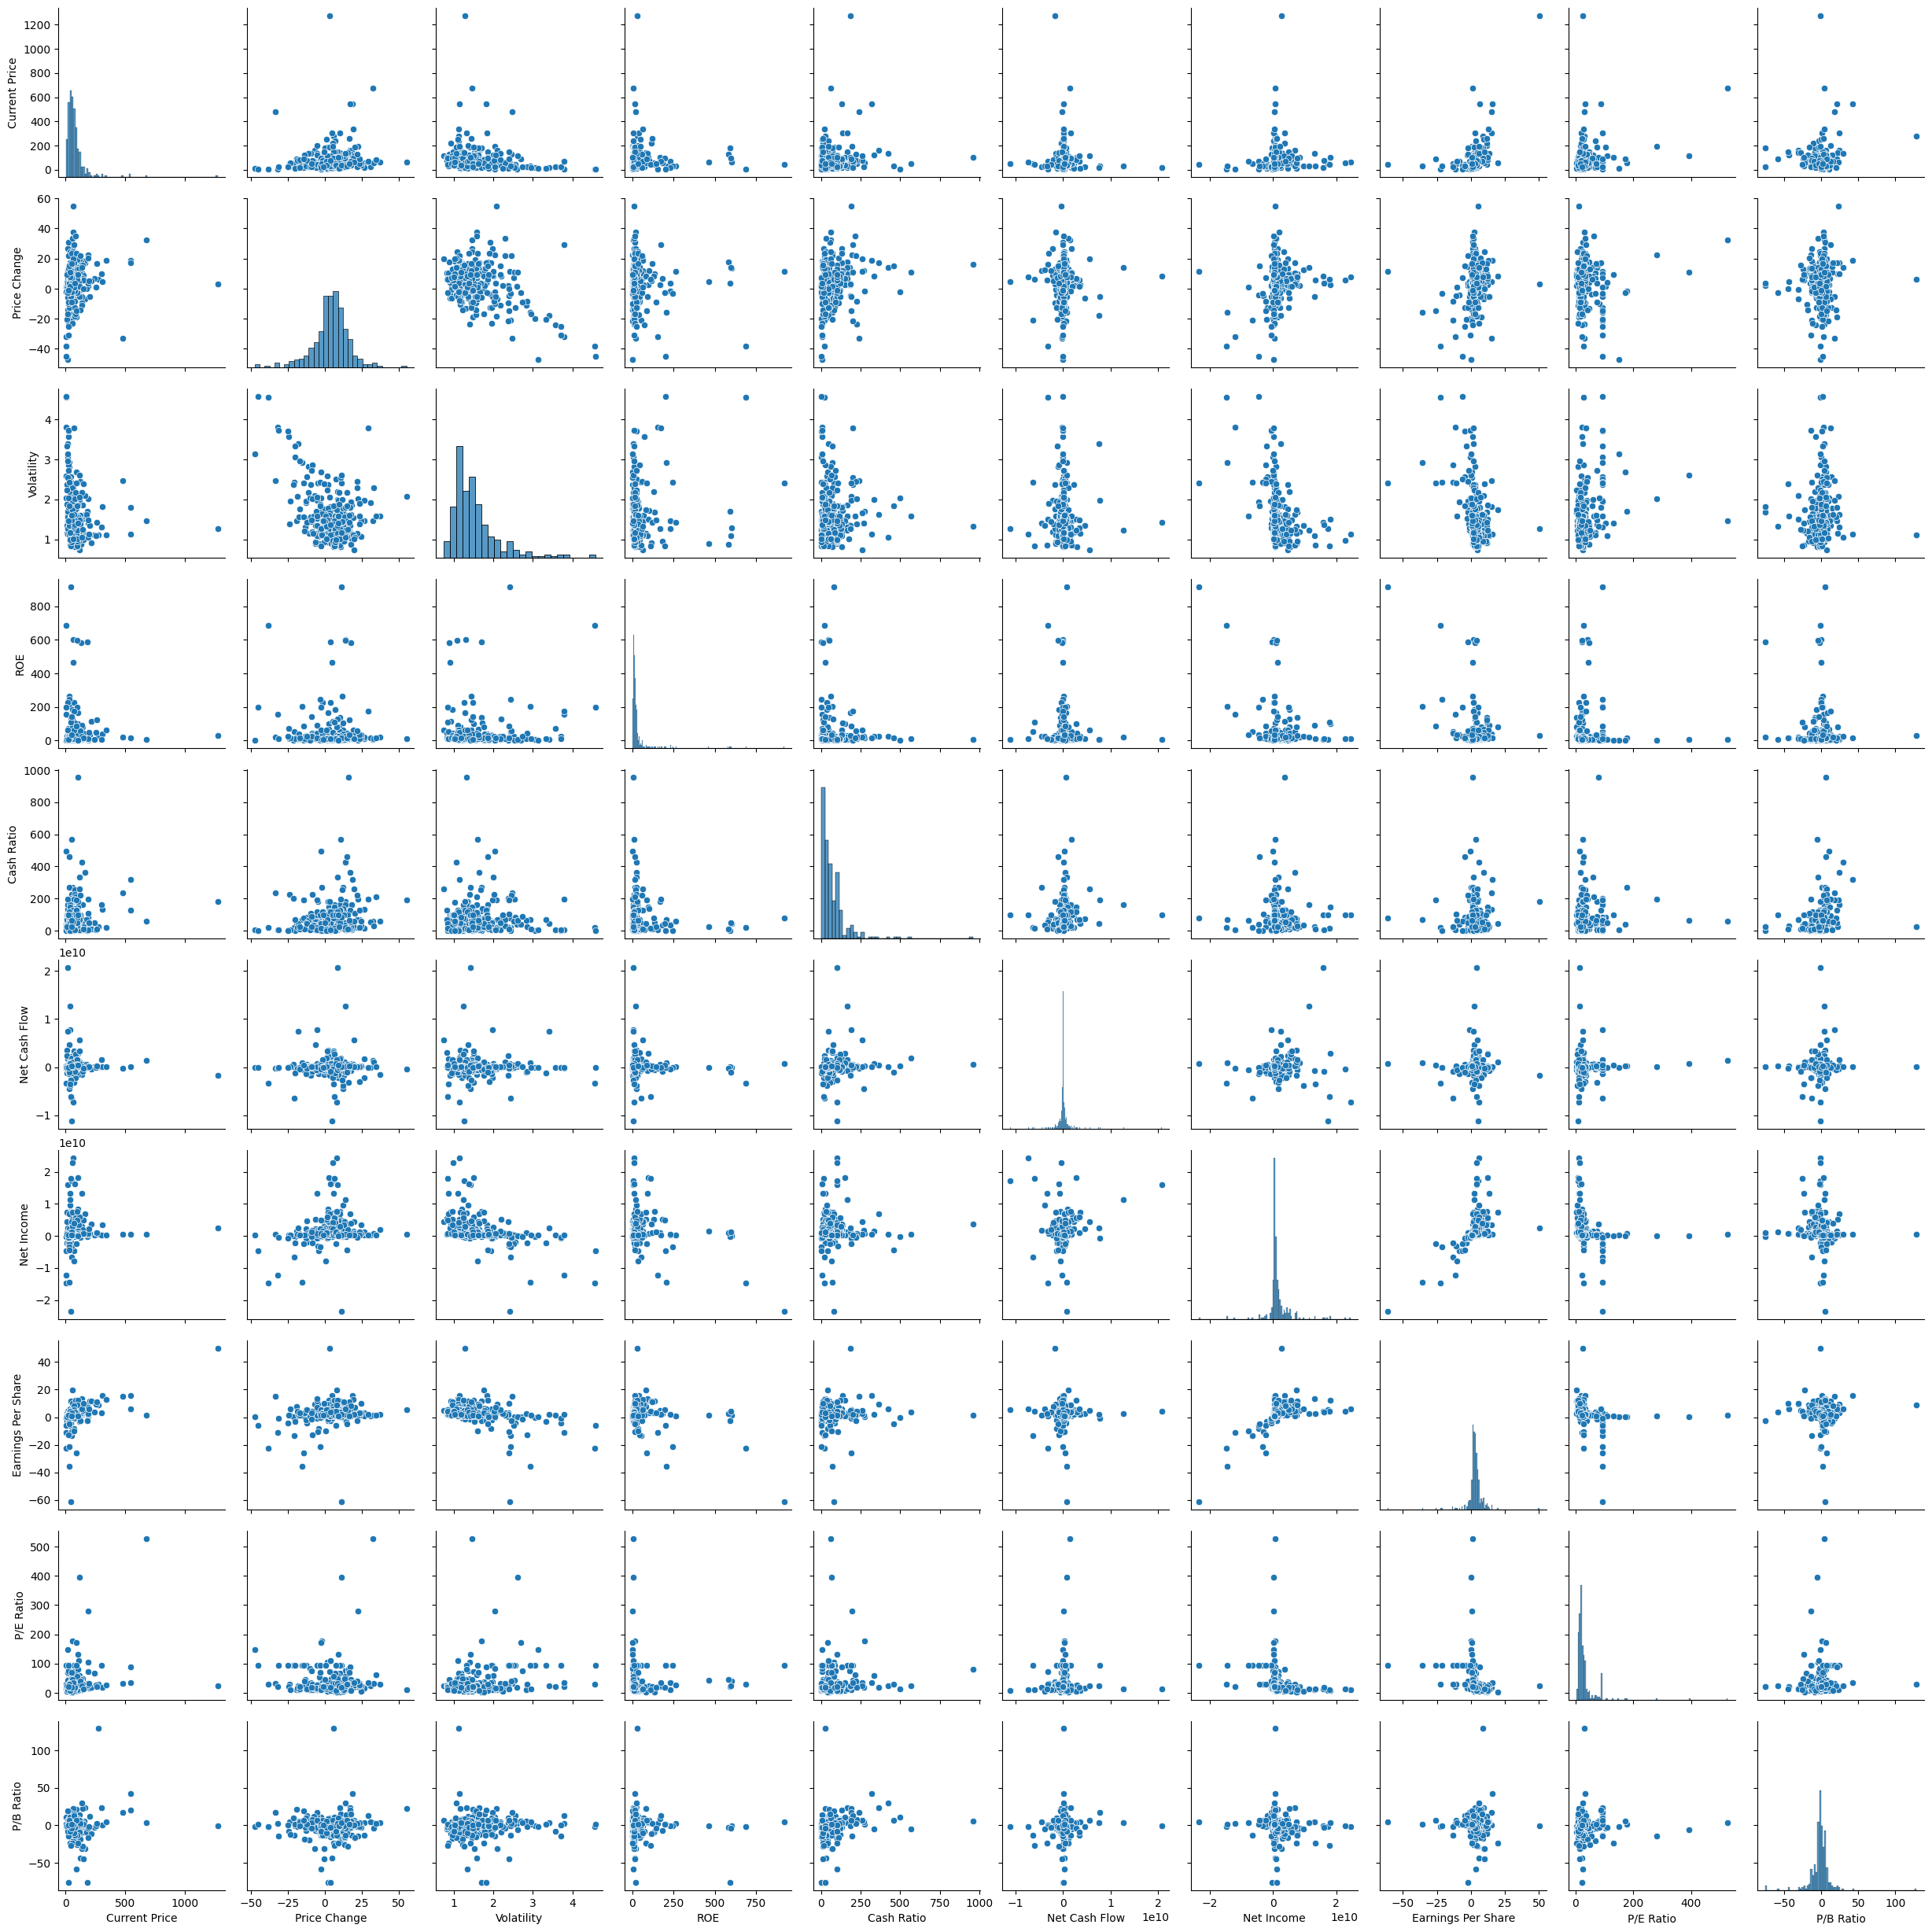

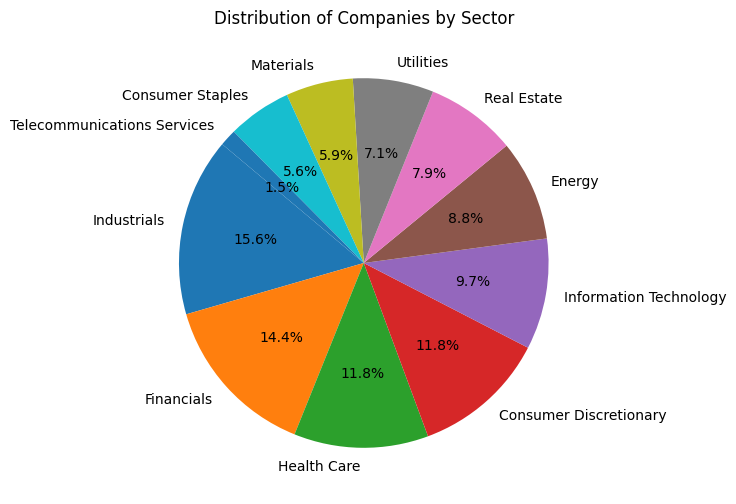

In [5]:
# Visualizing distributions of numeric variables
numeric_columns = ['Current Price', 'Price Change', 'Volatility', 'ROE', 'Cash Ratio', 'Net Cash Flow', 'Net Income', 'Earnings Per Share', 'P/E Ratio', 'P/B Ratio']

for col in numeric_columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(stock_data_df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

# Pairplot to visualize relationships
sns.pairplot(stock_data_df[numeric_columns])
plt.show()

# Pie chart for sector distribution
sector_counts = stock_data_df['GICS Sector'].value_counts()
plt.figure(figsize=(10, 6))
plt.pie(sector_counts, labels=sector_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Companies by Sector')
plt.show()

### Data Preprocessing

Duplicate values: 0


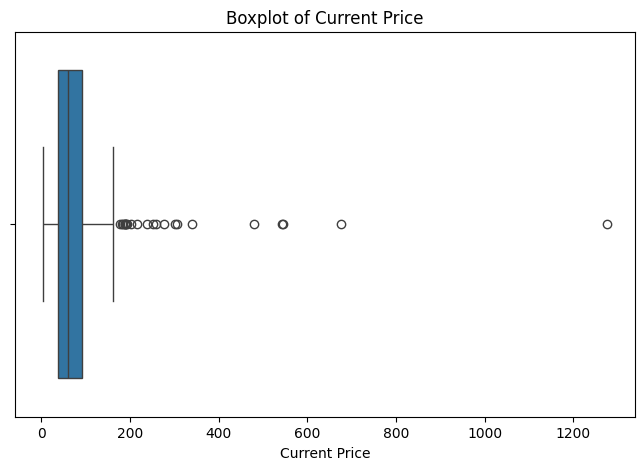

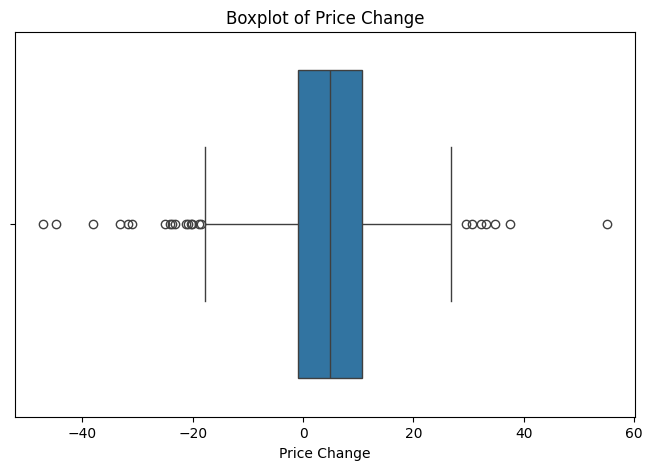

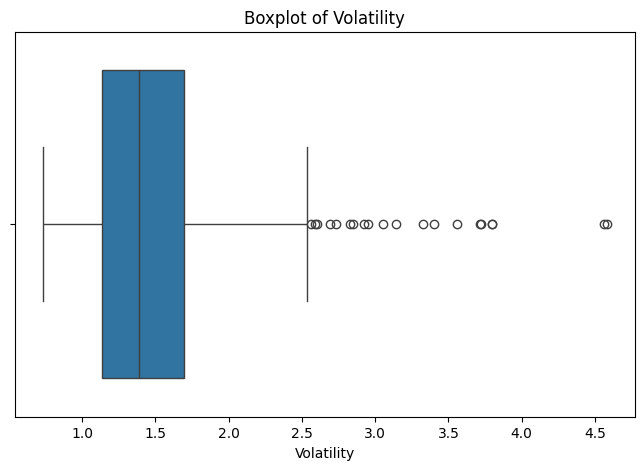

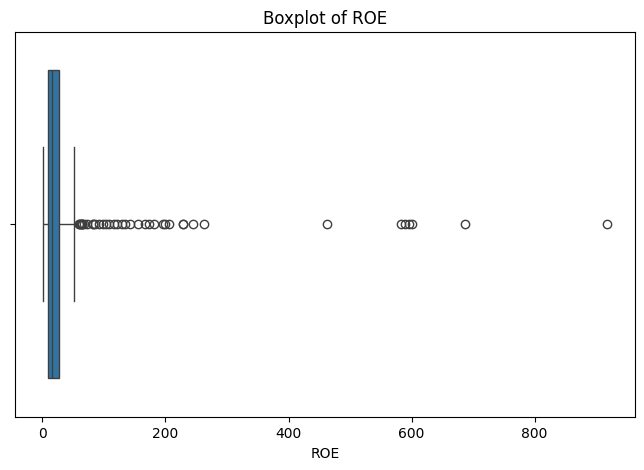

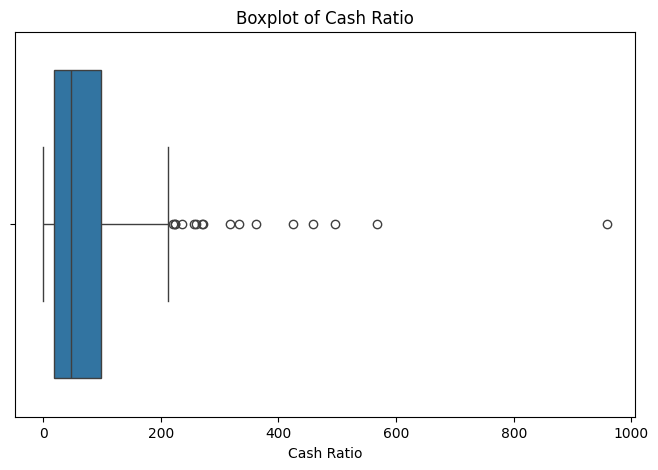

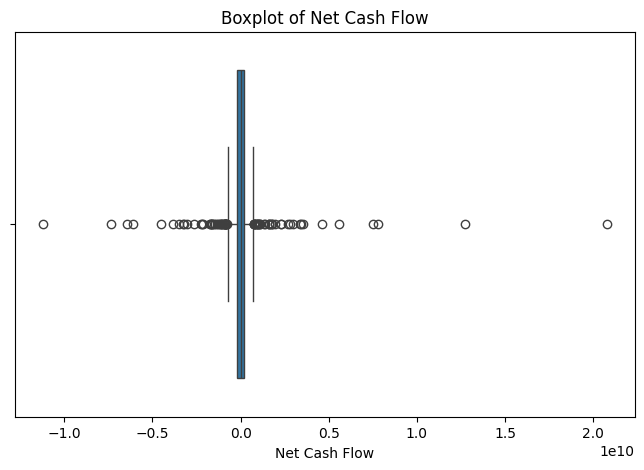

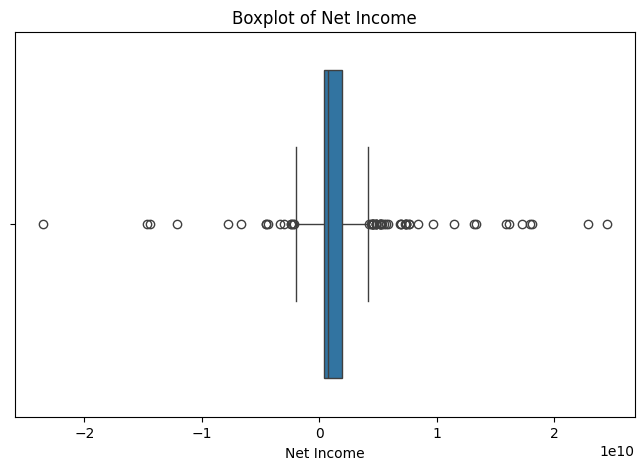

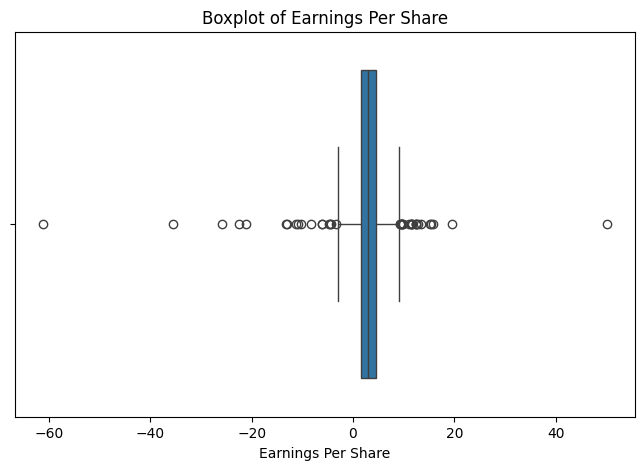

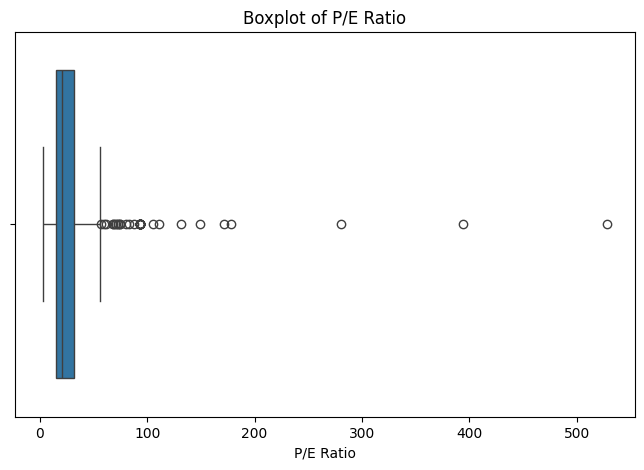

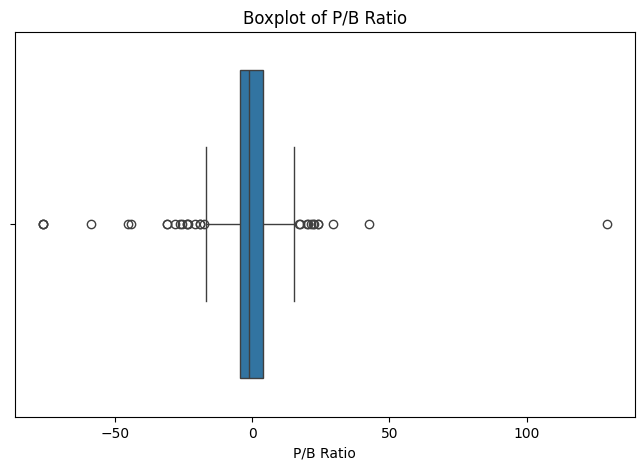

In [7]:
# Checking for duplicate values
duplicates = stock_data_df.duplicated().sum()
print(f'Duplicate values: {duplicates}')

# Handling missing values
# Calculate the mean only for numeric columns
numeric_means = stock_data_df[numeric_columns].mean()

# Fill missing values in numeric columns with their respective means
stock_data_df[numeric_columns] = stock_data_df[numeric_columns].fillna(numeric_means)

# Checking for outliers using boxplots
for col in numeric_columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=stock_data_df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

# Feature scaling
scaler = StandardScaler()
data_scaled = scaler.fit_transform(stock_data_df[numeric_columns])

### Applying K-means clustering

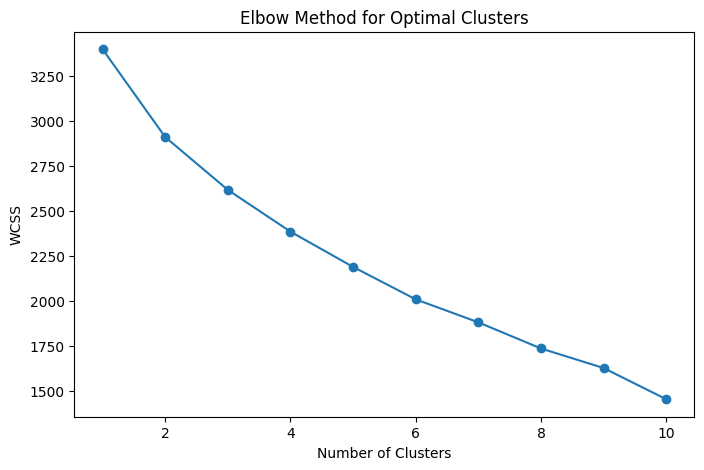

Silhouette Score for K-Means: 0.42640449133897074


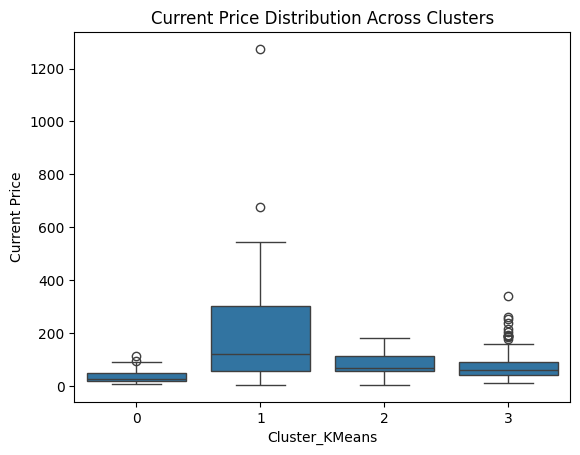

In [8]:
# Finding the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

# Applying K-Means Clustering with optimal clusters
optimal_k = 4  # Assume from the elbow curve
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
stock_data_df['Cluster_KMeans'] = kmeans.fit_predict(data_scaled)

# Checking silhouette score
silhouette_avg = silhouette_score(data_scaled, stock_data_df['Cluster_KMeans'])
print(f'Silhouette Score for K-Means: {silhouette_avg}')

# Cluster Profiling
sns.boxplot(x=stock_data_df['Cluster_KMeans'], y=stock_data_df['Current Price'])
plt.title('Current Price Distribution Across Clusters')
plt.show()

### Applying Hierarchical clustering

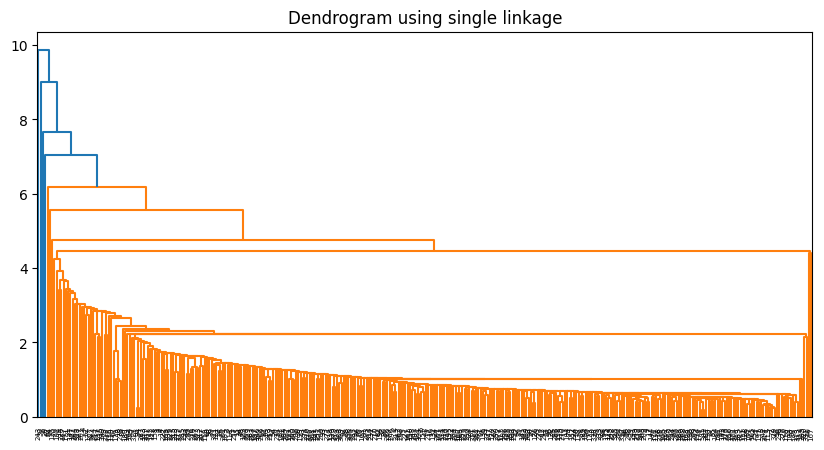

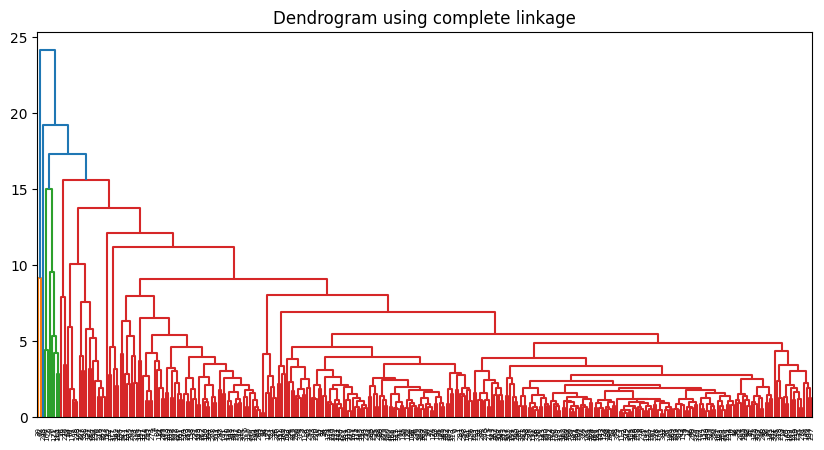

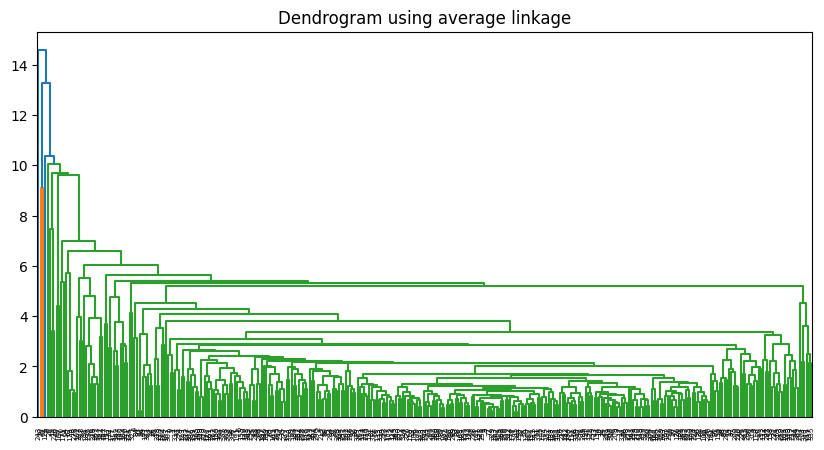

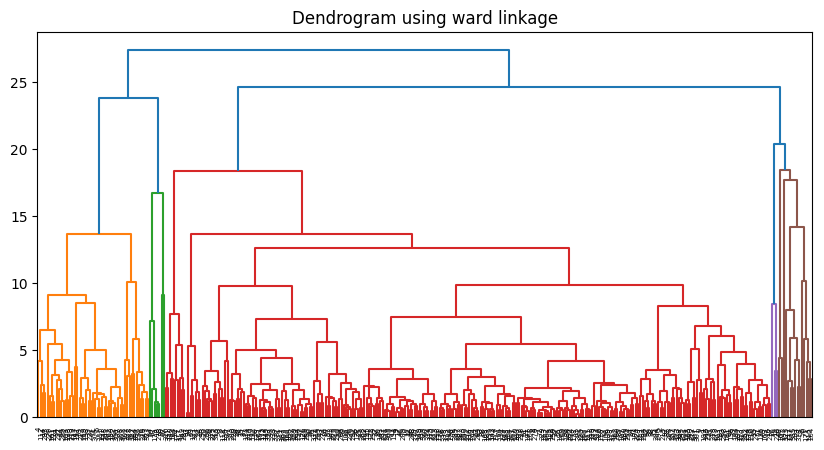

Cophenetic Correlation for single linkage: 0.9257979350911241
Cophenetic Correlation for complete linkage: 0.8156131306369379
Cophenetic Correlation for average linkage: 0.9334747007945994
Cophenetic Correlation for ward linkage: 0.587933659313373


In [9]:
# Apply Hierarchical clustering with different linkage methods
linkage_methods = ['single', 'complete', 'average', 'ward']
for method in linkage_methods:
    plt.figure(figsize=(10, 5))
    Z = linkage(data_scaled, method=method)
    dendrogram(Z)
    plt.title(f'Dendrogram using {method} linkage')
    plt.show()

# Checking cophenetic correlation for each linkage method
for method in linkage_methods:
    Z = linkage(data_scaled, method=method)
    coph_corr, _ = cophenet(Z, pdist(data_scaled))
    print(f'Cophenetic Correlation for {method} linkage: {coph_corr}')

# Applying Agglomerative Clustering with optimal linkage
optimal_clusters = 4  # Assume from dendrogram analysis
agg_clustering = AgglomerativeClustering(n_clusters=optimal_clusters, linkage='ward')
stock_data_df['Cluster_Hierarchical'] = agg_clustering.fit_predict(data_scaled)

### K-means vs Hierarchical Clustering

In [10]:
# Comparing K-Means and Hierarchical Clustering
comparison = pd.crosstab(stock_data_df['Cluster_KMeans'], stock_data_df['Cluster_Hierarchical'])
print(comparison)

Cluster_Hierarchical   0  1    2   3
Cluster_KMeans                      
0                      1  0    1  27
1                     17  0    6   2
2                      0  7    0   0
3                      0  0  259  20


### Actionable Insights and Recomendation

In [11]:
print("\nKey Insights:")
print("1. Stocks are grouped into distinct clusters based on key financial indicators.")
print("2. Diversified investment is recommended to mitigate risk, especially investing in clusters with low correlation.")
print("3. Investors can select clusters with high ROE and low volatility for stable returns.")
print("4. Companies in clusters with high P/E ratios may be overvalued; fundamental analysis is advised before investing.")


Key Insights:
1. Stocks are grouped into distinct clusters based on key financial indicators.
2. Diversified investment is recommended to mitigate risk, especially investing in clusters with low correlation.
3. Investors can select clusters with high ROE and low volatility for stable returns.
4. Companies in clusters with high P/E ratios may be overvalued; fundamental analysis is advised before investing.
